In [2]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [5]:
name_dataset = 'puteshestvi'

### load data

In [6]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(8245, 7)
CPU times: user 772 ms, sys: 0 ns, total: 772 ms
Wall time: 785 ms


In [7]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/grecha/,NaN,Россия,Россияне автостопом добрались до Эмиратов,В Объединенные Арабские Эмираты (ОАЭ) в среду ...,Путешествия
1,1999-10-22 12:00:00,https://lenta.ru/news/1999/10/22/kazan/,NaN,Экономика,Казанский аэропорт вышел на мировой уровень,Торжественная церемония открытия взлетно-посад...,Путешествия


### preprocess

* get dates

In [8]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 65.2 ms, sys: 4.43 ms, total: 69.6 ms
Wall time: 68.9 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [10]:
import preprocessing_tools as pr

In [11]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s


In [12]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/grecha/,NaN,Россия,Россияне автостопом добрались до Эмиратов,в объединенные арабские эмираты оаэ в среду пр...,Путешествия,"[(1999, 10, 06)]",1999,10
1,1999-10-22 12:00:00,https://lenta.ru/news/1999/10/22/kazan/,NaN,Экономика,Казанский аэропорт вышел на мировой уровень,торжественная церемония открытия взлетнопосадо...,Путешествия,"[(1999, 10, 22)]",1999,10


* cleanedNames

In [13]:
from cleanedNames import KeyProc
cn = KeyProc()

In [14]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


* lemmatization

In [15]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 25.1 s, sys: 0 ns, total: 25.1 s
Wall time: 25.1 s


* add docID

In [16]:
df['docID'] = list(range(df.shape[0]))

In [17]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[объединить, арабский, эмират, оаэ, среда, при..."
1,1,1999,10,"[торжественный, церемония, открытие, взлетнопо..."


In [18]:
print(df.shape)
df.isnull().sum()

(8245, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [19]:
df.year.min()

1999

## model

* prepare

In [20]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 89 ms, sys: 0 ns, total: 89 ms
Wall time: 88.2 ms


In [21]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [22]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/puteshestvi", num_batches=9)
CPU times: user 2.68 s, sys: 13 ms, total: 2.69 s
Wall time: 666 ms


In [23]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [24]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=05e559dd-628c-40ba-870c-5e0b2dcd101a, num_entries=7873)

In [25]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [29]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.12807762622833252
	SparsityPhiScore: 0.24196621775627136
	PerplexityScore: 2952.2138671875
	time: 0:00:07.245750
#topic 3.........
	SparsityThetaScore: 0.2863149344921112
	SparsityPhiScore: 0.3656378388404846
	PerplexityScore: 2596.471923828125
	time: 0:00:07.433727
#topic 4.........
	SparsityThetaScore: 0.3776834309101105
	SparsityPhiScore: 0.4375714361667633
	PerplexityScore: 2400.96337890625
	time: 0:00:07.635237
#topic 5.........
	SparsityThetaScore: 0.4353668987751007
	SparsityPhiScore: 0.5115711688995361
	PerplexityScore: 2255.84228515625
	time: 0:00:08.008719
#topic 6.........
	SparsityThetaScore: 0.50301194190979
	SparsityPhiScore: 0.541619062423706
	PerplexityScore: 2138.655029296875
	time: 0:00:08.048780
#topic 7.........
	SparsityThetaScore: 0.540518045425415
	SparsityPhiScore: 0.5779789686203003
	PerplexityScore: 2036.177734375
	time: 0:00:08.304865
#topic 8.........
	SparsityThetaScore: 0.5673590302467346
	SparsityPhiScore: 0.612838

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

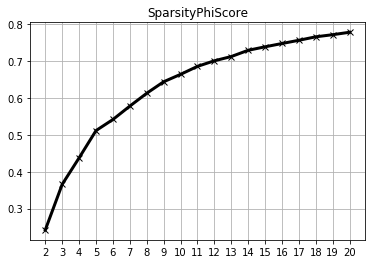

In [32]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [33]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [34]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}

Text(0.5, 1.0, 'SparsityThetaScore')

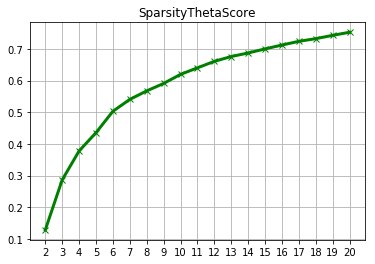

In [35]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [36]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [37]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 4, 0.6: 5, 0.7: 6}

Text(0.5, 1.0, 'PerplexityScore')

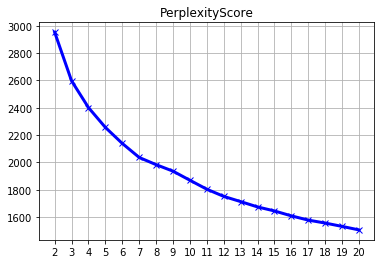

In [38]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [39]:
perplexity

[2952.2138671875,
 2596.471923828125,
 2400.96337890625,
 2255.84228515625,
 2138.655029296875,
 2036.177734375,
 1983.5289306640625,
 1935.8751220703125,
 1869.334716796875,
 1803.82275390625,
 1751.455078125,
 1713.245849609375,
 1674.34912109375,
 1644.8966064453125,
 1608.896728515625,
 1577.920654296875,
 1556.3575439453125,
 1531.8033447265625,
 1506.21630859375]

### select the best model

In [45]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 4, 0.6: 5, 0.7: 6}


In [66]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [67]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['египет' 'чартерный' 'республика' 'запрет' 'мера' 'президент'
 'авиасообщение' 'египетский' 'турецкий' 'ограничение']
topic_1: ['ресторан' 'хороший' 'мероприятие' 'фестиваль' 'опрос' 'респондент'
 'участие' 'блюдо' 'опросить' 'провести']
topic_2: ['рейтинг' 'войти' 'хороший' 'занять' 'топ' 'строчка' 'позиция' 'европа'
 'достаться' 'лидер']
topic_3: ['крым' 'регион' 'глава' 'развитие' 'ростуризм' 'чиновник' 'полуостров'
 'министр' 'проект' 'край']
topic_4: ['виза' 'документ' 'посольство' 'визовый' 'режим' 'оформление' 'въезд'
 'паспорт' 'срок' 'шенгенский']
topic_5: ['метр' 'поезд' 'километр' 'высота' 'минута' 'час' 'часы' 'дорога'
 'маршрут' 'путь']
topic_6: ['клиент' 'номер' 'деятельность' 'владелец' 'рекламный' 'алкоголь' 'фирма'
 'кампания' 'сеть' 'постоялец']
topic_7: ['шар' 'рекорд' 'южный' 'конюх' 'федор_конюх' 'америка' 'кругосветный'
 'экспедиция' 'мировой' 'конюхов']
topic_8: ['область' 'маршрут' 'отправиться' 'экскурсия' 'тур' 'группа' 'северный'
 'житель' 'посетить

### get topics-docs matrix

shape theta: (20, 8245)


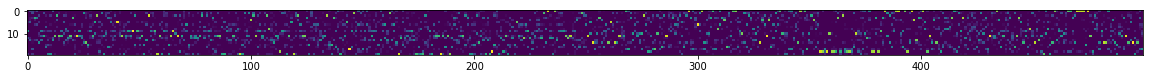

In [68]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [69]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
3000,0.000000,0.000000,0.0,0.834139,0.000000,0.000000,0.0,0.000000,0.138726,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.027135,0.000000,0.000000,0.0,0.000000
3001,0.285506,0.000000,0.0,0.058995,0.088764,0.011554,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.096077,0.292506,0.000000,0.000000,0.166599,0.0,0.000000
3002,0.000000,0.272666,0.0,0.000000,0.000000,0.115573,0.0,0.000000,0.038780,0.205008,0.071692,0.0,0.000000,0.000000,0.108351,0.125911,0.062018,0.000000,0.0,0.000000
3003,0.000000,0.023259,0.0,0.000000,0.000000,0.000000,0.0,0.181253,0.192375,0.369089,0.000000,0.0,0.234024,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3004,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.310031,0.000000,0.000000,0.0,0.558538,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.131431


## DataViz

In [70]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.049791,0.000000,0.000000,0.000000,0.080039,0.0,0.000000,0.0,0.00000,0.000000
1,1,1999,10,0.0000,0.000000,0.0,0.181925,0.000000,0.373178,0.000000,...,0.098492,0.067121,0.000000,0.102151,0.000000,0.0,0.159073,0.0,0.01806,0.000000
2,2,1999,12,0.0000,0.042791,0.0,0.121397,0.066537,0.025010,0.000000,...,0.000000,0.000000,0.027667,0.000000,0.000000,0.0,0.595710,0.0,0.00000,0.000000
3,3,1999,11,0.0617,0.000000,0.0,0.081972,0.545477,0.000000,0.191378,...,0.000000,0.000000,0.119473,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000
4,4,2000,1,0.0000,0.084570,0.0,0.162722,0.000000,0.062985,0.226123,...,0.000000,0.000000,0.000000,0.000000,0.019863,0.0,0.000000,0.0,0.00000,0.018414


In [71]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (223, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 10     0.000000  0.000000  0.000000  0.181925  0.000000  0.373178   
     11     0.061700  0.000000  0.000000  0.081972  0.545477  0.000000   
     12     0.000000  0.042791  0.000000  0.121397  0.066537  0.025010   
2000 1      0.000000  0.084570  0.887127  0.162722  0.000000  0.069799   
     3      1.005989  0.423474  0.311614  0.591354  0.337684  0.058510   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 10     0.000000  0.409574  0.334428  0.126167  0.148283  0.067121   
     11     0.191378  0.000000  0.000000  0.000000  0.000000  0.000000   
     12     0.000000  0.017965  0.025962  0.076960  0.000000  0.000000   
2000 1      0.226123  0.106060  0.000000  0.425323  0.000000  0.000000   
     3      0.181147  0.060621  0.116856  0.000000  0.355173  0.740224   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 10     0.000000  0.102151  0.080039  0.000000  0.159073  0.000000   
     11     0.119473  0.000000  0.000000  0.000000  0.000000  0.000000   
     12     0.027667  0.000000  0.000000  0.000000  0.595710  0.000000   
2000 1      0.000000  0.000000  0.019863  0.000000  0.000000  0.000000   
     3      0.025053  0.718912  0.241899  0.170103  0.091522  0.061229   

            topic_18  topic_19  
year month                      
1999 10     0.018060  0.000000  
     11     0.000000  0.000000  
     12     0.000000  0.000000  
2000 1      0.000000  0.018414  
     3      0.430412  0.078224

### straightforward matrix heatmap

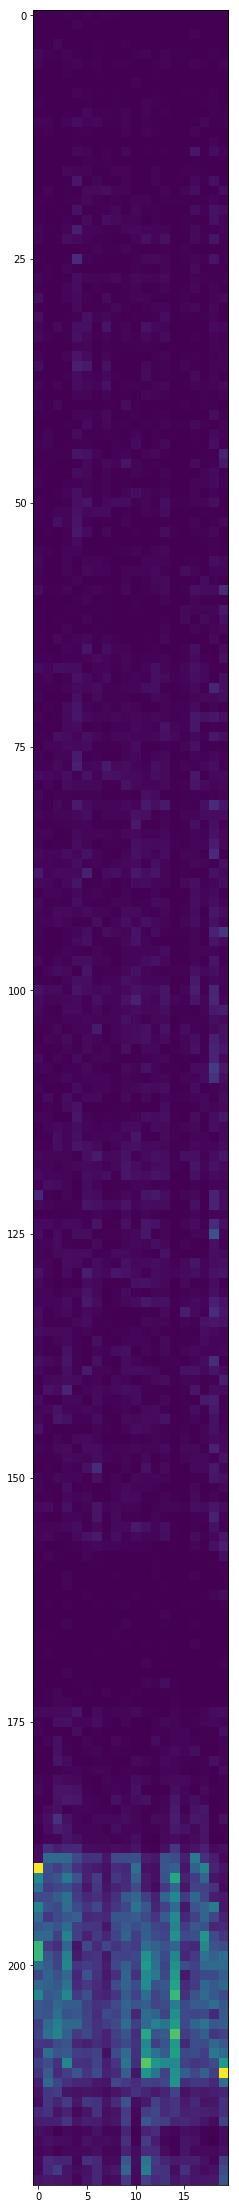

In [52]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [72]:
import pygal
from IPython.display import SVG, HTML

In [73]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [74]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [75]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [76]:
import joypy # !pip install joypy

In [77]:
print(joined.shape)
joined.head()

(8245, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.049791,0.000000,0.000000,0.000000,0.080039,0.0,0.000000,0.0,0.00000,0.000000
1,1,1999,10,0.0000,0.000000,0.0,0.181925,0.000000,0.373178,0.000000,...,0.098492,0.067121,0.000000,0.102151,0.000000,0.0,0.159073,0.0,0.01806,0.000000
2,2,1999,12,0.0000,0.042791,0.0,0.121397,0.066537,0.025010,0.000000,...,0.000000,0.000000,0.027667,0.000000,0.000000,0.0,0.595710,0.0,0.00000,0.000000
3,3,1999,11,0.0617,0.000000,0.0,0.081972,0.545477,0.000000,0.191378,...,0.000000,0.000000,0.119473,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000
4,4,2000,1,0.0000,0.084570,0.0,0.162722,0.000000,0.062985,0.226123,...,0.000000,0.000000,0.000000,0.000000,0.019863,0.0,0.000000,0.0,0.00000,0.018414


In [78]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.080039,0.0,0.000000,0.0,0.00000,0.000000,1999-10-01
1,1,1,1999,10,0.0000,0.000000,0.0,0.181925,0.000000,0.373178,...,0.067121,0.000000,0.102151,0.000000,0.0,0.159073,0.0,0.01806,0.000000,1999-10-01
2,2,2,1999,12,0.0000,0.042791,0.0,0.121397,0.066537,0.025010,...,0.000000,0.027667,0.000000,0.000000,0.0,0.595710,0.0,0.00000,0.000000,1999-12-01
3,3,3,1999,11,0.0617,0.000000,0.0,0.081972,0.545477,0.000000,...,0.000000,0.119473,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,1999-11-01
4,4,4,2000,1,0.0000,0.084570,0.0,0.162722,0.000000,0.062985,...,0.000000,0.000000,0.000000,0.019863,0.0,0.000000,0.0,0.00000,0.018414,2000-1-01


In [79]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(197880, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-12-01,index,2.0
3,1999-11-01,index,3.0
4,2000-1-01,index,4.0


In [80]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(164900, 3)


topic_8     8245
topic_19    8245
topic_3     8245
topic_1     8245
topic_17    8245
topic_11    8245
topic_7     8245
topic_6     8245
topic_4     8245
topic_18    8245
topic_15    8245
topic_13    8245
topic_5     8245
topic_10    8245
topic_0     8245
topic_9     8245
topic_12    8245
topic_16    8245
topic_2     8245
topic_14    8245
Name: topic, dtype: int64

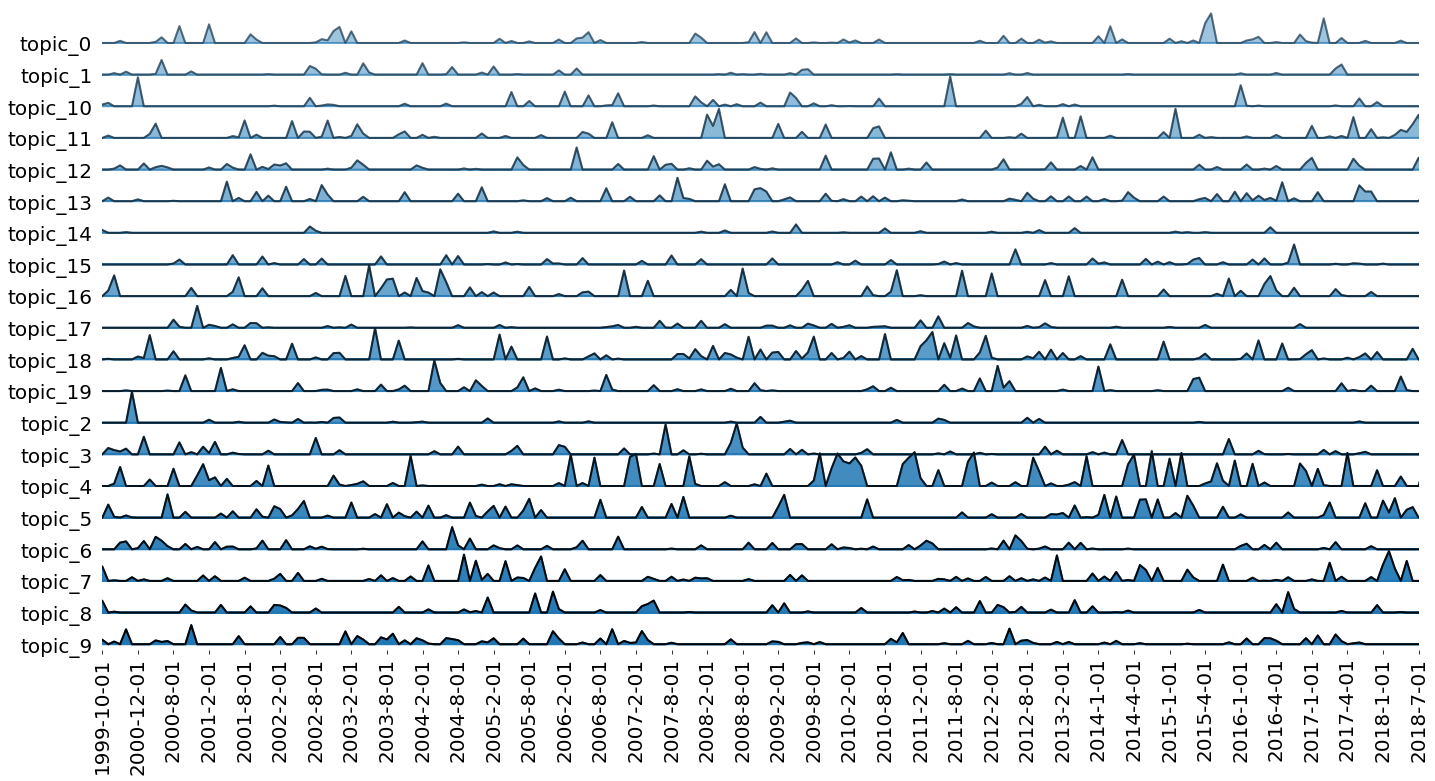

In [81]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [82]:
fig.savefig(f'data/visualization/{name_dataset}_joypy')